# PyHSMM Experiment Collection


This notebook documents al experiments mentioned in the thesis and can be used to reproduce the results.

---

## 0. Setup of the Environment

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhsmm.basic.distributions import PoissonDuration, NegativeBinomialDuration, NegativeBinomialFixedRDuration
from pyhsmm.models import WeakLimitHDPHSMM, HSMM
from pybasicbayes.distributions.gaussian import Gaussian
from pybasicbayes.distributions.multinomial import Categorical
from pybasicbayes.distributions.mixturedistribution import DistributionMixture
import pickle
from pyhsmm.util.eaf_processing import to_eaf
import random
import sys
import ipywidgets as widgets
import datetime

sys.path.insert(1,'/home/daniel/PycharmProjects/virtamed')

from helpers import get_list_of_files, load_zipped_pickle

np.random.seed(1001)
random.seed(1001)

In [2]:
def read_data_from_disk(root_dir, limit=None):
    file_list = get_list_of_files(root_dir)
    obs_array = []
    records = []
    data_frames = []
    eaf_fnames = []
    for fname in file_list:
        print('Got data for ' + fname)
        data_dict = load_zipped_pickle(fname)
        obs_array.append(data_dict['obs'])
        records.append(data_dict['record'])
        data_frames.append(data_dict['decode_df'])
        eaf_fnames.append(data_dict['eaf_path'])
    
    return obs_array, records, data_frames, eaf_fnames

---


---
## 1. Baseline HSMM1

First, we will use a simple model that does not make use of the any information derived from the SSL task.


The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

---

### 1a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [3]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/2018_01_18_13_18_40_675.zip
Got data for /home/daniel/PycharmProjects

---

###  1b.  Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 1b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [4]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

#### 1b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [5]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 1b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [6]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

#### 1b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [7]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### 1b. v) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [8]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[5.32708010e-07,5.32708010e-07,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.84109660e-02,5.91118976e-01],[4.47512210e-07,4.47512210e-07,4.47512210e-07,4.47512210e-07,6.90605262e-02,9.66847367e-02,4.47512210e-07,4.47512210e-07,6.90605262e-02,6.90605262e-02,4.47512210e-07,4.47512210e-07,2.51380316e-01,1.93369473e-01,6.90605262e-02,1.82319789e-01],[6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,2.53966416e-01,6.98407643e-01,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,1.58729010e-02,3.17458020e-02,6.03170237e-07,6.03170237e-07],[4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,2.24136787e-01,3.04596147e-01,4.25285186e-07,4.25285186e-07,1.78160010e-01,2.93101952e-01,4.25285186e-07,4.25285186e-07],[6.48502787e-07,6.48502787e-07,6.48502787e-07,6.48502787e-07,4.39365032e-02,5.27238038e-02,6.48502787e-07,6.48502787e-07,4.39365032e-02,4.39365032e-02,6.48502787e-07,6.48502787e-07,5.67659621e-01,1.59928872e-01,4.39365032e-02,4.39365032e-02],[3.72383551e-07,3.72383551e-07,3.72383551e-07,3.72383551e-07,1.04602121e-01,1.04602121e-01,3.72383551e-07,3.72383551e-07,1.04602121e-01,1.04602121e-01,3.72383551e-07,3.72383551e-07,3.80751720e-01,2.00836072e-01,3.72383551e-07,3.72383551e-07]]
cat_emission_weights = np.array(cat_emission_weights)

---

### 1c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [9]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [10]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

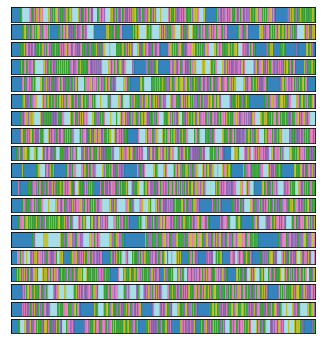

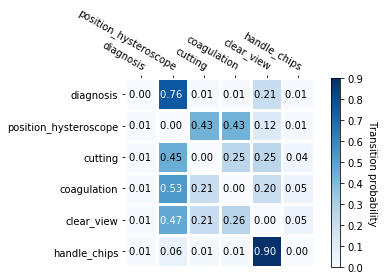

In [11]:
fig = hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 1d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [12]:
likes = hsmm_model.EM_fit(maxiter=5000)

/home/daniel/.conda/envs/virtamed/lib/python3.7/site-packages/pyhsmm-0.1.6-py3.7-linux-x86_64.egg/pyhsmm/internals/hsmm_states.py:92: RuntimeWarning: divide by zero encountered in log
  self._log_trans_matrix = np.log(self.trans_matrix)
/home/daniel/.conda/envs/virtamed/lib/python3.7/site-packages/pyhsmm-0.1.6-py3.7-linux-x86_64.egg/pyhsmm/internals/hsmm_states.py:367: RuntimeWarning: divide by zero encountered in log
  self.trans_potentials, np.log(self.pi_0),


In [13]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -6791.648839885895


In [14]:
baseline_hsmm_model = hsmm_model

In [15]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/basline_hsmm1_'+ timestamp+'/'
os.mkdir(output_dir)

<Figure size 432x288 with 0 Axes>

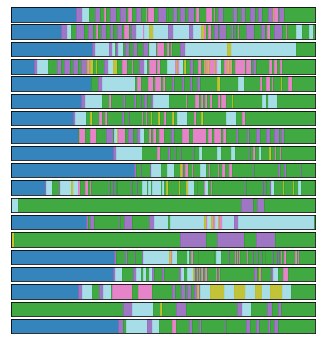

In [16]:
plt.figure()
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


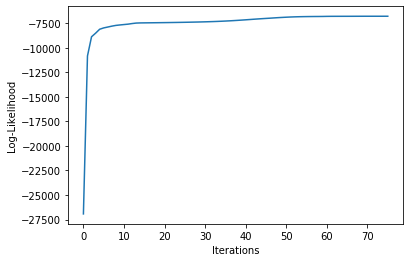

In [17]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.4841783926975423

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.10573610e-15 3.43493886e-14 0.00000000e+00 0.00000000e+00
 3.20644740e-15 9.83820048e-15 0.00000000e+00 0.00000000e+00
 2.25148710e-13 1.28104358e-13 1.17246483e-02 9.88275352e-01]

Model summary for state position_hysteroscope
-----------------------------------------
   Duration model
      NegativeBinomial: r=32.494, p=0.3566030795141543

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.23747826e-16 1.23149391e-04 0.00000000e+00 0.00000000e+00
 3.04591518e-15 3.06871132e-04 0.00000000e+00 1.12860930e-04
 4.57664242e-04 9.98544879e-01 0.00000000e+00 4.54575549e-04]

Model summary for state cutting
----------

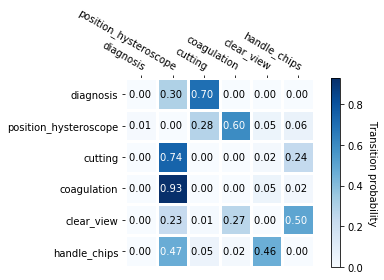

In [18]:
plt.close()
hsmm_model.total_summary(state_list)

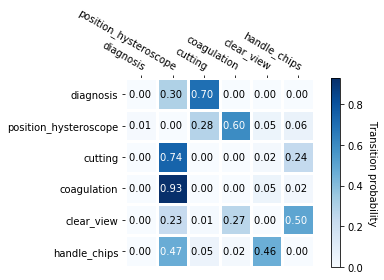

In [19]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 1e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [20]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 1f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [21]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 1g.  Experiment Summary

When we look at the resulting segmentation using the model, that does not make use of the RSD or NPT observable we see that the HSMM favors segmentations, where we have more shorter activities in general. This might be favored actually over the smooth activities, which we observed before. However, we also see more missclassification of certain activities (especially the state handle_chips and place tool are often switched). Moreover we see that for instance the clear_view activity is also more often misclassified as a handle_chips or place_tool activity.

We will try to improve the results by adding the movement direction to the observables.

---
---

## 2. Baseline HSMM2

The complete setup of the experiment of the Baseline HSMM2 described in the remainder of the section looks as follows:

**Observables:**
 * HandleMov(fwds/still/bwds)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

### 2b. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [22]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/2018_01_18_13_18_40_675.zip
Got data for 

---

###  2b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 2b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [23]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

#### 2b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [24]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 2b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [25]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

#### 2b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [26]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### 2b. v) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [27]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,8.09172810e-02,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,2.00481622e-01,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,8.45404428e-02],[2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.54328622e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,8.13643502e-02,8.00520220e-02,3.28082057e-02,6.16794267e-02,2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,3.28082057e-02,4.06821751e-02,2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,4.33068315e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,7.08657243e-02,4.46191598e-02,3.28082057e-02,4.98684727e-02],[4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.09659885e-01,1.09659885e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,5.82928864e-03,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.09659885e-01,1.09659885e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.40364653e-01,3.86002796e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.16585773e-02,1.74878659e-02,4.43025936e-07,4.43025936e-07],[2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,8.82344533e-02,1.01603310e-01,2.64703360e-07,2.64703360e-07,6.68442828e-02,1.09624624e-01,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,6.68442828e-02,6.68442828e-02,2.64703360e-07,2.64703360e-07,6.68442828e-02,6.68442828e-02,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,8.28869107e-02,1.06950852e-01,2.64703360e-07,2.64703360e-07,8.28869107e-02,9.35819959e-02,2.64703360e-07,2.64703360e-07],[4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,1.70276976e-01,5.98549371e-02,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,3.09594502e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,1.88852646e-01,5.98549371e-02,2.57995418e-02,2.57995418e-02],[2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,9.83296173e-02,6.30793771e-02,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,1.16882375e-01,7.23557561e-02,2.11501441e-07,2.11501441e-07]]
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,8.09173396e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.00481767e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,8.45405041e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.54328901e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.13644142e-02,8.00520850e-02,3.28082316e-02,6.16794753e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,4.06822071e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.33068656e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,7.08657801e-02,4.46191949e-02,3.28082316e-02,4.98685120e-02],[3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.10618018e-01,1.10618018e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,4.42472073e-03,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.10618018e-01,1.10618018e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.41591063e-01,3.89375424e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,8.84944146e-03,1.32741622e-02,3.36278776e-07,3.36278776e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,8.82346656e-02,1.01603554e-01,1.97859553e-07,1.97859553e-07,6.68444437e-02,1.09624888e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,8.28871101e-02,1.06951110e-01,1.97859553e-07,1.97859553e-07,8.28871101e-02,9.35822211e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.70277082e-01,5.98549741e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.88852763e-01,5.98549741e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,9.83297541e-02,6.30794649e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.16882538e-01,7.23558568e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)

### 2c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [28]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [29]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

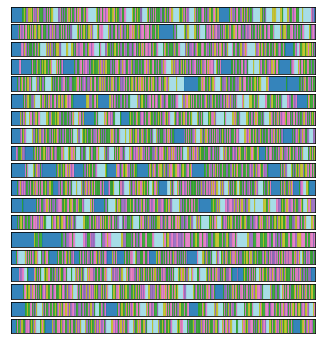

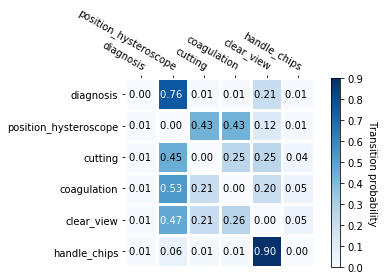

In [30]:
fig = hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 2d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [31]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [32]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -22208.44759252645


In [33]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/baseline_hsmm2_'+ timestamp+'/'
os.mkdir(output_dir)

<Figure size 432x288 with 0 Axes>

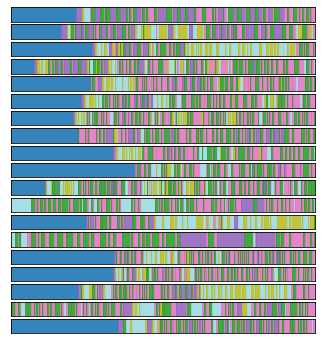

In [34]:
plt.figure()
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


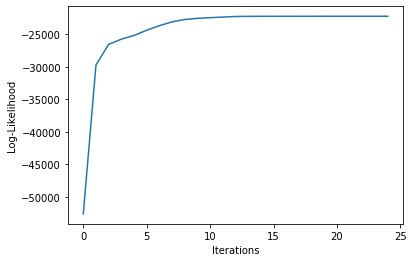

In [35]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.4719327956915118

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.99014400e-16 2.27788933e-15 0.00000000e+00 0.00000000e+00
 1.37791780e-14 1.27710652e-14 0.00000000e+00 0.00000000e+00
 6.83107277e-14 6.78410518e-14 5.33055314e-03 4.39178368e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.83490810e-15 2.32975173e-15 1.70577700e-03 1.46269964e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46576983e-15 4.94649839e-14 0.00000000e+00 0.00000000e+00
 1.03593288e-14 1.88436764e-14 0.00000000e+00 0.00000000e+00
 8.27245212e-14 6.66427477e-14 4.90410889e-03 4.02611229e-01]

Model summa

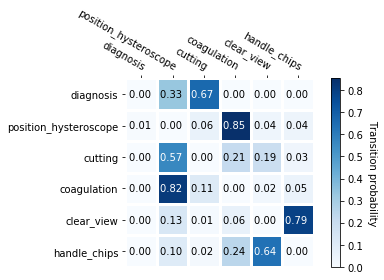

In [36]:
plt.close()
hsmm_model.total_summary(state_list)

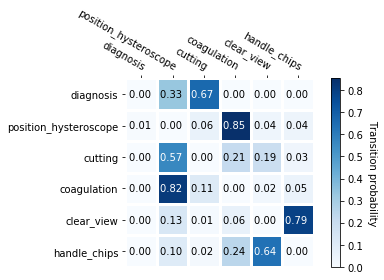

In [37]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 2e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [38]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 2f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [39]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 2g.  Experiment Summary

The resulting segmentation, where we try to compensate the loss of information by excluding the NPT and RSD observable with introducing the HandleMov observable, is significantly worse. We see that now the segmentation favors very short sequences. An explanation is that similar to the Valve2_OutChange variable this observable is subject to high inter-sample variability. As a consequence the initialization, which is based on the annotated sequence 692 does not generalize well.

While it is slighlty more expressed in this case as well, we see that the more symbols we have the more often those naturally change throughout the series. Those changes of symbols often trigger a switch of the state. It seems that at least the MPE path obtained by the Viterbi is obtained by almost deterministic linkages between observing a certain symbol and a specific state. It would be interested to derive a probabilistic measure of the individual states for the individual observation.

---
---

## 3. NPT HSMM

The following setup describes the experiment conducted for the NPT HSMM:

**Observables:**
 * NextPedalType (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 
As for the model components we make the following distributional assumptions:
 
 * categorical emission model
 * categorical transition model
 * negative binomial duration distribution model
 * categorical initial state distribution model

### 3a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of the experiments with the NPT HSMM.

In [40]:
root_dir = '/home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_

---

###  3b. Configuration of the NPT HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 3b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [41]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

#### 3b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [42]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.120, 0.410, 0.410, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 3b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [43]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 1

#### 3b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [44]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### 3b. vi) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [45]:
cat_emission_dirichlet_prior_alpha_0=0
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.05553536e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.59315242e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.66137313e-02,8.39890728e-02,3.28082316e-02,8.66137313e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,6.56164631e-02,4.06822071e-02,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,3.28082316e-02],[3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.41591016e-01,3.89375293e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,8.84943849e-03,1.76988770e-02,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,7.48657769e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.04277332e-01,1.41710221e-01,1.97859553e-07,1.97859553e-07,7.21919991e-02,1.28341332e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,7.75395546e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,5.26310979e-02,5.05671333e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.59957258e-01,3.19914517e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.72341046e-01,6.29509211e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.68830333e-01,8.90533622e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)


### 3c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [46]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [47]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

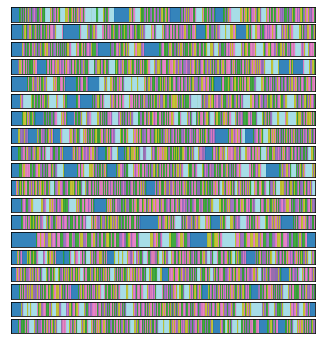

In [48]:
fig=hsmm_model.plot()

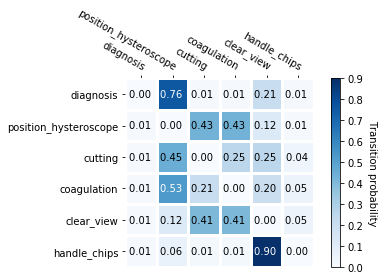

In [49]:
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 3d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [50]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [51]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -12727.214409465862


In [52]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/npt_hsmm_'+ timestamp+'/'
os.mkdir(output_dir)

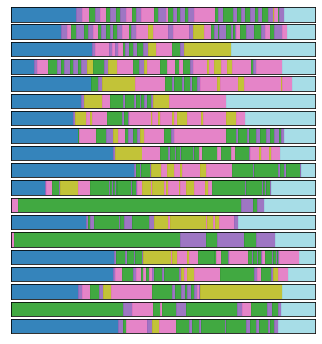

In [53]:
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


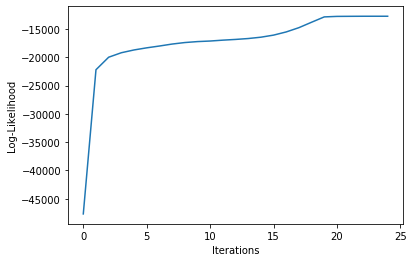

In [54]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.48448499864199107

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.09151666e-14 6.47563834e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.44617564e-14 1.93451761e-13 1.19378255e-02 9.33489258e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.25125547e-15 1.78290376e-14 0.00000000e+00 0.00000000e+00
 8.86468038e-14 4.57272548e-14 0.00000000e+00 5.45729168e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.36490452e-14 6.86883160e-14 0.00000000e+00 0.00000000e+00]

Model summ

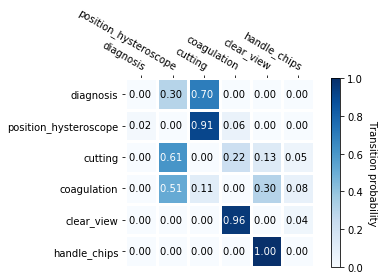

In [55]:
plt.close()
hsmm_model.total_summary(state_list)

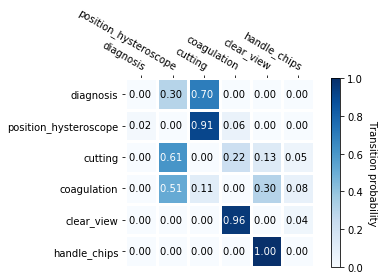

In [56]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 3e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [57]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 3f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [58]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 3g. Experiment Summary

The decoded sequences of the HSMM look quite promising. In fact the results are actually good however, we see that the model tend to favor longer smoother activities. It might be favored to have somewhat more granulary segmentation of the individual activties. A way to achieve this is to change the parameters of the duration distribution. However, we see that the changes of the activities are realtively strongly associated with the change of individual observables. Unless those do not change, the model decides to stay in a certain activity. That intuitively makes sense, but might also suggest that more observables could lead to a more better segmentation on a higher level of granularity.

---

---

## 4. NPT HSMM with predicted NPT labels

In the following we will conduct experiments, where we use the prediction that are made from our trained CNNs for NextPedalType-related variables instead of the ground truth data. We will see how that affects the performance of the individual models.

The first experiment that we will conduct has the following setup:

**Observables:**
 * NextPedalTypePredicted (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 
We will not make use of the Bayesian formulation of the HSMM model components namely the emission, transition, duration and initial state distribution model. For that reason even though we define sometimes respective hyperparameters, those will be chosen in such a way that they essential are uninformative priors. The results will thus be purely identified by the data.
 
As for the model components we make the following distributional assumptions:
 
 * categorical emission model
 * categorical transition model
 * negative binomial duration distribution model
 * categorical initial state distribution model

### 4a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [59]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity

---

###  4b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [60]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [61]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [62]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 1

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [63]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
#duration_negbin_rs = np.array([2000.171344, 100.477453 , 100.446388,  150.481516,  100.454518, 1000.125309])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])
#duration_negbin_ps = np.array([0.05717104, 0.07135187, 0.07054303, 0.07130548, 0.07084420, 0.09145630])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [64]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.33615819,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429],[0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.03115265,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.07943925,0.07632399,0.01557632,0.07943925,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.05451713,0.02492212,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632],[0.01798561,0.01798561,0.01798561,0.01798561,0.03057554,0.13129496,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.02158273,0.02517986,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561],[0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0234657,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0433213,0.06859206,0.01805054,0.01805054,0.02166065,0.05956679,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.02527076,0.01805054,0.01805054,0.01805054],[0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01766784,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.04240283,0.04004711,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.16489988,0.0188457,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.17903416,0.05418139,0.01177856,0.01177856],[0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.13356766,0.05799649,0.01757469,0.01757469]]
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.05553536e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.59315242e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.66137313e-02,8.39890728e-02,3.28082316e-02,8.66137313e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,6.56164631e-02,4.06822071e-02,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,3.28082316e-02],[3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.41591016e-01,3.89375293e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,8.84943849e-03,1.76988770e-02,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,7.48657769e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.04277332e-01,1.41710221e-01,1.97859553e-07,1.97859553e-07,7.21919991e-02,1.28341332e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,7.75395546e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,5.26310979e-02,5.05671333e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.59957258e-01,3.19914517e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.72341046e-01,6.29509211e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.68830333e-01,8.90533622e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)

### 4c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [65]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [66]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

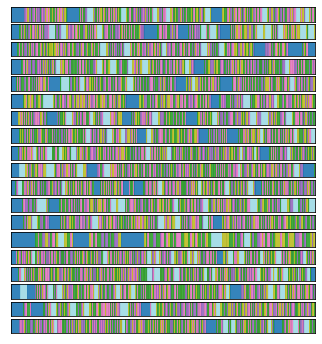

In [67]:
fig=hsmm_model.plot()

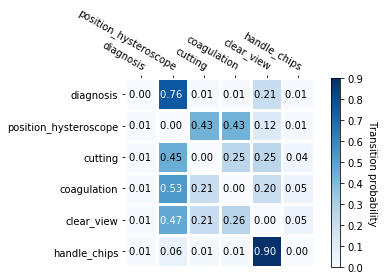

In [68]:
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 4d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [69]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [70]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -15512.783480083637


In [71]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/npt_pred_hsmm_'+ timestamp+'/'
os.mkdir(output_dir)

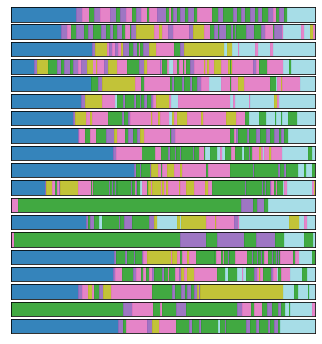

In [72]:
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


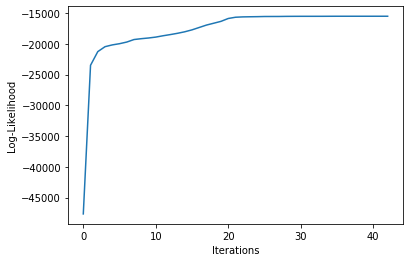

In [73]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.48418110344847354

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.42830854e-15 1.47069608e-14 0.00000000e+00 0.00000000e+00
 6.93370878e-18 1.78236876e-15 0.00000000e+00 0.00000000e+00
 1.09988509e-14 4.40412793e-14 1.17246805e-02 9.74205703e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.51876125e-16 6.63740635e-16 0.00000000e+00 0.00000000e+00
 2.84806097e-15 4.43377036e-15 0.00000000e+00 0.00000000e+00
 7.60911802e-15 1.13388431e-14 0.00000000e+00 1.40696166e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.72175651e-16 1.95968000e-14 0.00000000e+00 0.00000000e+00]

Model summ

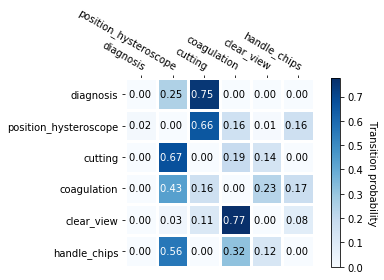

In [74]:
plt.close()
hsmm_model.total_summary(state_list)

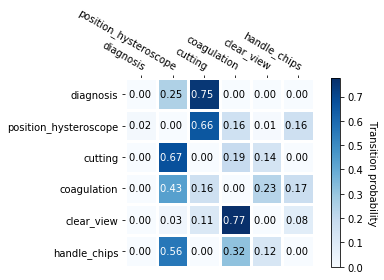

In [75]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 4e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [76]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 4f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [77]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 4g. Experiment Summary

When looking at the decoded sequence, we see that the performance is actually comparable to the one, we got for the ground truth data. We see that sometimes short coagualtion tasks are sometimes not identified or longer tasks tend to end slighlty early. This can be explained by the fact, that at these times the prediction for the next pedal type are off. 

Better predictions would certainly improve the quality as we see a better quality of the segmentation for the ground truth data. Another way could be to put more initial weight on symbols that basically represent a wrong prediction of the next pedal type, e.g. symbols that have a certain pedal activated but the next pedal type taking on the value of a different pedal.


---
---

## 5. NPT HSMM with RSDLevel

In the following we catch up that idea and add a categorical version of the remaining surgery duration information to the model and see how the results change.

The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * NextPedalType (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * RSDProgressLevel (start/center/end)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

### 5a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [78]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/2018_01_18_13_18_40_675.zip
Got data for /home/daniel/P

---

###  5b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [91]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

#### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.

In [92]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [93]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

#### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [94]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [95]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-01,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02],[9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.78388174e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,3.36389129e-02,3.26195519e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,2.39549834e-02,1.27420125e-02,2.24259419e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,2.54840249e-02,1.58000954e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02],[1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,6.06076437e-02,1.66671020e-01,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,5.03402304e-03,1.00680461e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07],[1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.87471177e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,4.00406282e-02,5.44141871e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.77204349e-02,4.92807732e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.97738005e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07],[1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.38310778e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.35128322e-02,2.25907603e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,7.14605684e-02,1.42921137e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.02855807e-02,1.15258981e-02,6.82333169e-02,2.81231914e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02],[7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,6.32379091e-02,3.33562597e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08]]
cat_emission_weights = [[1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.24752442e-01,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02],[8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.78388338e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,3.36389437e-02,3.26195818e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,2.39550054e-02,1.27420241e-02,2.24259625e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,2.54840483e-02,1.58001099e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02],[1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,6.08354120e-02,1.67297383e-01,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,3.80221325e-03,7.60442649e-03,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07],[7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.87471974e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,4.00407392e-02,5.44143379e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.77205118e-02,4.92809098e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.97738830e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08],[1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.38310892e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.35128517e-02,2.25907791e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,7.14606277e-02,1.42921255e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.02855975e-02,1.15259077e-02,6.82333735e-02,2.81232148e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02],[6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.32380080e-02,3.33563119e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08]]
cat_emission_weights = np.array(cat_emission_weights)

### 5c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [96]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [97]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

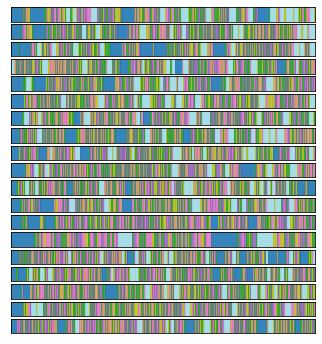

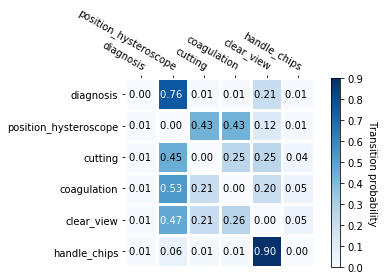

In [98]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 5d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [99]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [100]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -25086.25550500013


In [101]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/npt_rsp_hsmm_'+ timestamp+'/'
os.mkdir(output_dir)

<Figure size 432x288 with 0 Axes>

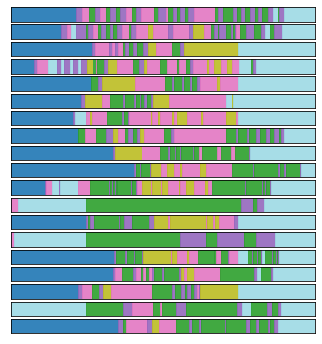

In [102]:
plt.figure()
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


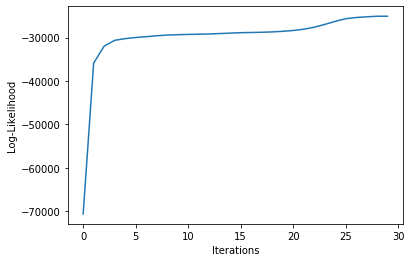

In [103]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.48426225425646413

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50608702e-16 1.48952753e-16 9.62306535e-16
 0.00000000e+00 3.62555314e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.68788400e-17 1.24928115e-16 1.20867461e-15 3.55932338e-15
 0.00000000e+00 8.13882936e-16 1.19379143e-02 7.80214433e-01
 0.00000000e+00 1.53274292e-01 0.00000000e+00 0.00000000e+00
 0.00000000e

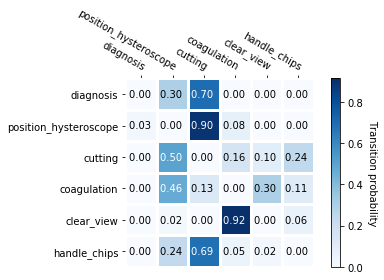

In [104]:
plt.close()
hsmm_model.total_summary(state_list)

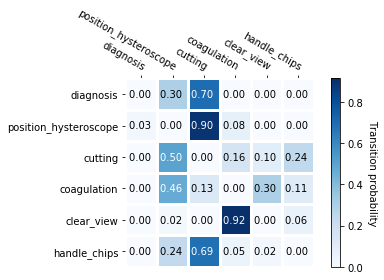

In [105]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

### 5e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [106]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 5f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [107]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 5g. Experiment Summary

The decoded sequence indeed tends to have shorter sequences in general. We also see a marginal improvement in the sense that for no longer handle chips is the starting sequence for any trajectory. Before handle_chips was fitted to be the starting activity for the sequence 673. That is very surprising anyways. Probably a pedal is falsely reported to be active - we will investigate that.

In summary however, I would say that the other HSMM yielded the less granular but somewhat better results.

---
---

## 6. Update gate HSMM

### 6a. Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [108]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/2018_01_18_13_18_40_675.zip
Got data for /home/daniel/PycharmProjects

---

###  6b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [109]:
state_list = ['diagnosis', 'position_hysteroscope', 'cutting', 'coagulation', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [110]:
initial_state_transition_likelihood = [
  [0.000, 0.770, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.000, 0.000, 0.435, 0.430, 0.120, 0.010],       #place tool
  [0.000, 0.460, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.000, 0.540, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.000, 0.460, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.000, 0.070, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [111]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [112]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [113]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[2.75361712e-07,2.75361712e-07,2.75361712e-07,2.75361712e-07,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,2.75361712e-07,2.75361712e-07,2.75361712e-07,2.75361712e-07,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.05554882e-01],[2.12598064e-07,2.12598064e-07,2.12598064e-07,2.12598064e-07,3.28083432e-02,3.28083432e-02,3.28083432e-02,4.59316804e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,1.19422369e-01,1.16797702e-01,2.12598064e-07,2.12598064e-07,2.12598064e-07,2.12598064e-07,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,6.16796851e-02],[2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,9.05791614e-02,9.05791614e-02,1.15941327e-01,3.18838648e-01,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,7.24633291e-03,1.44926658e-02,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,9.05791614e-02,9.05791614e-02,9.05791614e-02,9.05791614e-02,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07],[1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,5.27424843e-02,5.27424843e-02,8.22782755e-02,1.11814067e-01,6.11812818e-02,5.27424843e-02,5.69618830e-02,1.07594668e-01,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02],[3.80803793e-07,3.80803793e-07,3.80803793e-07,3.80803793e-07,2.57997150e-02,2.57997150e-02,2.57997150e-02,3.09596580e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,1.72342096e-01,6.29513046e-02,1.86789937e-01,5.67593730e-02,3.80803793e-07,3.80803793e-07,3.80803793e-07,3.80803793e-07,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02],[1.29172581e-07,1.29172581e-07,1.29172581e-07,1.29172581e-07,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,1.32075335e-01,6.96661109e-02,3.62844328e-02,3.62844328e-02,1.29172581e-07,1.29172581e-07,1.29172581e-07,1.29172581e-07,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02]]
cat_emission_weights = np.array(cat_emission_weights)

### 6c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [114]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [115]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

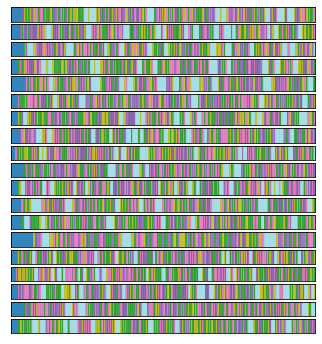

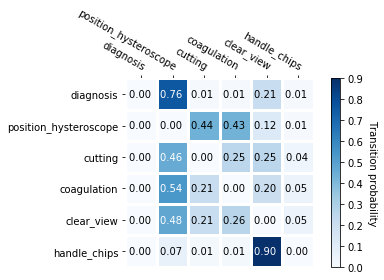

In [116]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 6d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [117]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [118]:
print('Log-Likelihood at convergence ', likes[-1])

Log-Likelihood at convergence  -9022.894521095497


In [119]:
update_gate_hsmm_model = hsmm_model

In [120]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/update_gate_hsmm_'+ timestamp+'/'
os.mkdir(output_dir)

<Figure size 432x288 with 0 Axes>

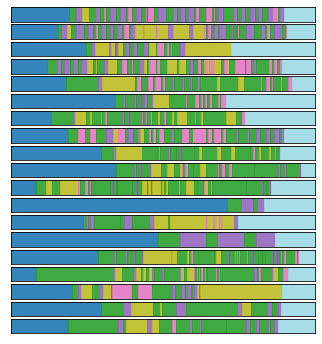

In [121]:
plt.figure()
hsmm_model.plot()
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


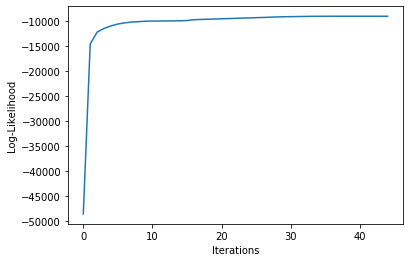

In [122]:
plt.close()
plt.figure()
#plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Complete Model Summary
###############################
Model summary for state diagnosis
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.5077343582986503

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.90383629e-15 7.80179183e-14
 0.00000000e+00 0.00000000e+00 3.66451981e-15 3.44212086e-14
 3.59623370e-14 1.47568402e-13 1.62490855e-13 3.62622840e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.08580184e-04 3.67722165e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.17160368e-04
 0.00000000e+00 0.00000000e+00 3.45250255e-02 9.60572012e-01]

Model summary for state position_hysteroscope
-----------------------------------------
   Duration model
      NegativeBinomial: r=32.494, p=0.3693902403467051

   Emission model
      Categorical with weights=[0.00000000e+000 0.00000000e+000 0.00000000e

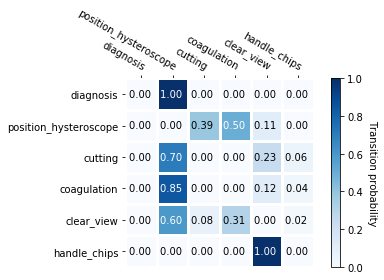

In [123]:
plt.close()
hsmm_model.total_summary(state_list)

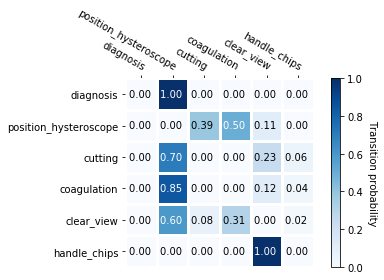

In [124]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

### 6e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [125]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 6f. Save model to disk

In [126]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

### 6g. Experiment Summary

Segmentation seems superior to all previous ones.

---
---
---

## Visualization of the segmentation of the 692 sequence

In [127]:
baseline_segmentation = baseline_hsmm_model.stateseqs[2]
update_gate_segmentation = update_gate_hsmm_model.stateseqs[2]
ground_truth_692 = np.array(['DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips'])

In [128]:
state_dict = {0:'DX', 1:'place_loop', 2:'cutting_loop', 3:'coag_loop', 4:'clear_view', 5:'handle_chips'}
baseline_segmentation_encoded = np.array([state_dict[state] for state in baseline_segmentation])
update_gate_segmentation_encoded = np.array([state_dict[state] for state in update_gate_segmentation])
inverse_state_dict = {v:k for k,v in state_dict.items()}
ground_truth_segmentation_num = np.array([inverse_state_dict[state] for state in ground_truth_692])

In [129]:
tmp_hsmm = update_gate_hsmm_model

In [130]:
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(baseline_segmentation))
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(update_gate_segmentation))
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(ground_truth_segmentation_num))
tmp_hsmm.states_list = update_gate_hsmm_model.states_list[-3:]

In [156]:
import matplotlib.patches as mpatches
color_dict = update_gate_hsmm_model._get_colors()
patch_list = []
state_dict_thesis = {0:'diagnosis', 1:'position\nhysteroscope', 2:'cutting', 
                     3:'coagulation', 4: 'clear view', 5:'handle chips'}
for k,v in color_dict.items():
    v = v[0], v[1], v[2], 0.9
    patch = mpatches.Patch(color=v, label = state_dict_thesis[k])
    patch_list.append(patch)

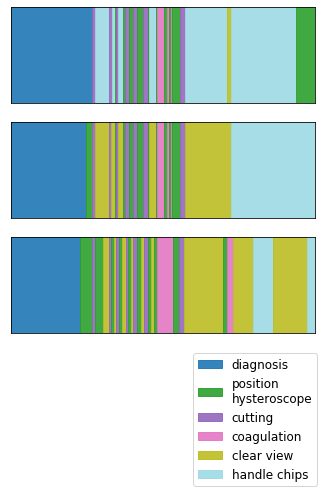

In [157]:
tmp_hsmm.plot()
plt.legend(handles=patch_list, bbox_to_anchor=(1.026, -0.15),
          fancybox=True, shadow=False, ncol=1, prop={"size":12})